In [1]:
!pip install gym tensorflow numpy matplotlib


In [2]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random

# Create the CartPole environment
env = gym.make('CartPole-v1')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
env.seed(42)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[42]

In [4]:
def create_q_model():
    model = tf.keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=(env.observation_space.shape[0],)),
        layers.Dense(24, activation='relu'),
        layers.Dense(env.action_space.n, activation='linear')
    ])
    return model

# Create the Q-network
q_model = create_q_model()
q_model_target = create_q_model()
q_model_target.set_weights(q_model.get_weights())

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.Huber()


In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size=100000):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Create replay buffer
replay_buffer = ReplayBuffer()


In [9]:
def train_q_network(episodes, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, batch_size=64, target_update_freq=10):
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        state = np.expand_dims(state, axis=0)
        episode_reward = 0

        done = False
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = q_model.predict(state)
                action = np.argmax(q_values[0])

            next_state, reward, done, _ = env.step(action)
            next_state = np.expand_dims(next_state, axis=0)

            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = np.concatenate(states)
                next_states = np.concatenate(next_states)

                q_values_next = q_model_target.predict(next_states)
                targets = rewards + (1 - np.array(dones)) * gamma * np.amax(q_values_next, axis=1)

                q_values = q_model.predict(states)
                for i, action in enumerate(actions):
                    q_values[i][action] = targets[i]

                q_model.compile(optimizer=optimizer, loss=loss_function)

        if episode % target_update_freq == 0:
            q_model_target.set_weights(q_model.get_weights())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_history.append(episode_reward)

        if episode % 10 == 0:
            print(f'Episode {episode}, Reward: {episode_reward}, Epsilon: {epsilon}')

    return rewards_history

# Train the Q-network
rewards_history = train_q_network(episodes=20)


2/2 [==============================] - 0s 6ms/step
Episode 0, Reward: 12.0, Epsilon: 0.995
2/2 [==============================] - 0s 5ms/step
Episode 10, Reward: 31.0, Epsilon: 0.946354579813443
2/2 [==============================] - 0s 5ms/step


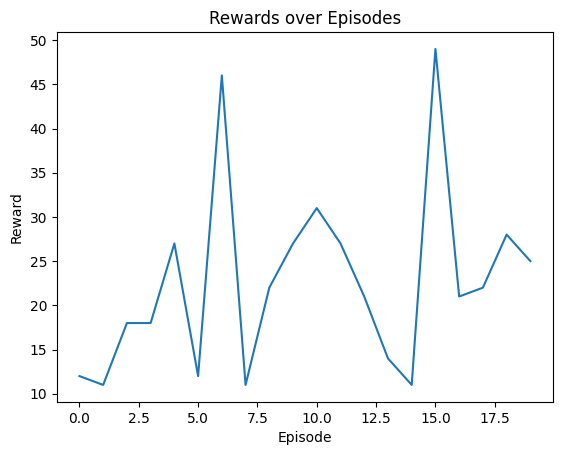

In [10]:
# Plot the rewards history
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards over Episodes')
plt.show()
